## Árboles de decisión: Clasificación

Lo primero es importarnos nuestras librerías y luego puntualizar que aunque en las sesiones prácticas, por una cuestión de tiempos, no vamos a hacer todo el proceso de modelado, no olvides que sí que tendrás que hacerlo cuando te enfrentes a ellos en prácticas y en tu vida profesional. Aquí está preparado para ir al lío directamente. Por eso no perdamos tiempo.

In [4]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.datasets import load_diabetes
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

import seaborn as sns

# para que la salida de este notebook sea estable en todas las ejecuciones
np.random.seed(42)

# Pintar!
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


### Entrenar y visualizar

Para nuestro ejemplo vamos a emplear un dataset que ya conoces el "Iris dataset", sí el de las flores con el que has trabajado en varios ejercicios ya. Lo cargamos y ya además construimos el modelo sobre él, ya que el Iris Dataset viene limpito y preparado.

Además, un detalle importante de los Arboles: NO NECESITAN ESCALADO, NI PREPARACION  (si puede que necesiten limpieza y conversión de categórica a numérica)

In [5]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target



In [6]:
df_X = pd.DataFrame(iris.data[:,2:], columns = iris.feature_names[2:])
df_X

,petal length (cm),petal width (cm)
0,1.4,0.2
1,1.4,0.2
2,1.3,0.2
3,1.5,0.2
4,1.4,0.2
...,...,...
145,5.2,2.3
146,5.0,1.9
147,5.2,2.0
148,5.4,2.3


In [7]:
tree_clf = DecisionTreeClassifier(max_depth=2,
                                  random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

Observa que hemos introducido ya un "hiperparámetro" (veremos los más importantes al finalizar las sesiones de modelado programático y los repasaremos en el siguiente bloque de sesiones de esta unidad): 
* **max_depth**: La máxima profundidad del árbol en niveles. Si es None, los nodos se expanden hasta que todas las hojas son puras o hasta que todas las hojas contienen menos muestras que `min_samples_split`.
* **min_samples_split**: El número mínimo de muestras necesarias para dividir un nodo interno. Es decir que no creará un nodo si al hacerlo este no contiene ese mínimo número de muestras.


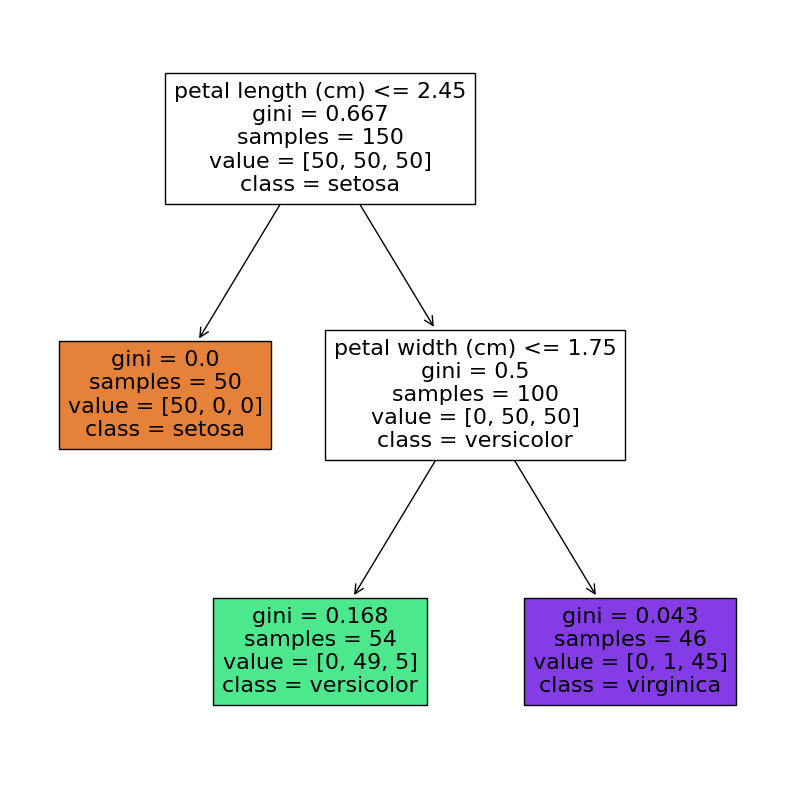

In [8]:
from sklearn.tree import plot_tree

plt.figure(figsize=(10,10))
sklearn.tree.plot_tree(tree_clf,
               feature_names=iris.feature_names[2:],
               class_names=iris.target_names,
               filled = True); # Colorea los cuadros

Veamos las fronteras que crean esos "splits" de los árboles (no hace falta que "memorices" el código siguiente, pero siempre puedes "quedártelo"):

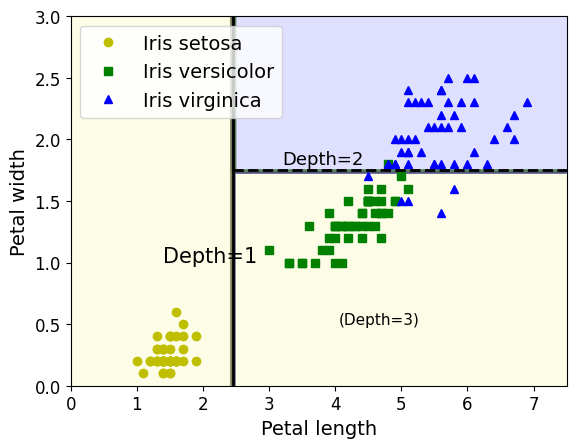

In [9]:
from matplotlib.colors import ListedColormap


clf = tree_clf
axes=[0, 7.5, 0, 3]
x1s = np.linspace(axes[0], axes[1], 100)
x2s = np.linspace(axes[2], axes[3], 100)
x1, x2 = np.meshgrid(x1s, x2s)
X_new = np.c_[x1.ravel(), x2.ravel()]
y_pred = clf.predict(X_new).reshape(x1.shape)
custom_cmap = ListedColormap(['#fafab0','#9898ff'])
plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "gs", label="Iris versicolor")
plt.plot(X[:, 0][y==2], X[:, 1][y==2], "b^", label="Iris virginica")
plt.axis(axes)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.40, 1.0, "Depth=1", fontsize=15)
plt.text(3.2, 1.80, "Depth=2", fontsize=13)
plt.text(4.05, 0.5, "(Depth=3)", fontsize=11)
plt.show();

En este caso es fácil ver los limites porque sólo tenemos dos features, pero no esperes que puedas pintar estos límites en futuros modelos con árboles, como mucho el árbol de decisión (Que de alguna forma ya está bien porque permite explicar el modelo muy bien).

### Predecir las clases y la probabilidad de las clases

Lo positivo de usar un framework es que se mantienen los métodos de los objetos para poder hacer las cosas. En este sentido, el clasificador sobre árboles binarios también permite predicciones y obtener probabilidades de una forma similar a como lo hacíamos con la regresión logística aplicada a clasificación:

In [10]:
tree_clf.predict_proba([[4, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [11]:
tree_clf.predict([[4, 1.5]])

array([1])

Como puedes ver hasta ahora no hay mucha diferencia (mientras no entremos de lleno en los hiperparámetros) entre la forma en la que se llaman y entrenan los diferentes tipos de modelos que hemos visto. Pero si hay algo importante a tener en cuenta con los árboles.

### High Variance: Sensibilidad a la hora de entrenar el conjunto de datos

El principal problema de los árboles de decisión es que son muy sensibles a pequeñas variaciones en los datos de entrenamiento. Por ejemplo, si sólo se limina el Iris versicolor más ancho del conjunto de entrenamiento del iris (el que tiene pétalos de 4,8 cm de largo y 1,8 cm de ancho) y se entrena un nuevo Árbol de decisión podemos obtener un modelo completamente diferente. Es decir, sí se ajusta muy bien a los datos a.k.a Overfitting y peor generalización. 

Veámoslo:

In [12]:
X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)] # la flor Iris versicolor más ancha

array([[4.8, 1.8]])

In [13]:
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

DecisionTreeClassifier(max_depth=2, random_state=40)

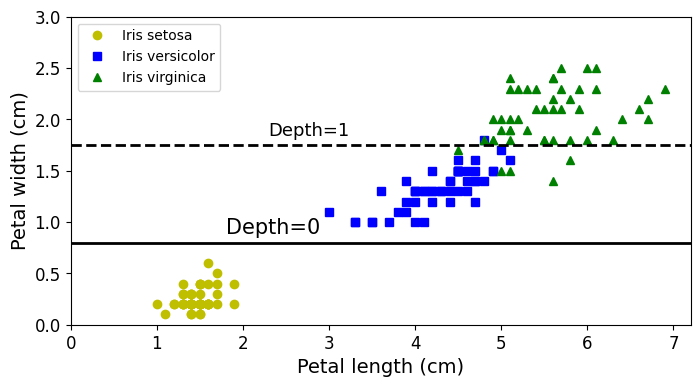

In [14]:
plt.figure(figsize=(8, 4))
y_pred = tree_clf_tweaked.predict(X)
#plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)

for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
             style, label=f"Iris {name}")

th0, th1 = tree_clf_tweaked.tree_.threshold[[0, 2]]
plt.plot([0, 7.2], [th0, th0], "k-", linewidth=2)
plt.plot([0, 7.2], [th1, th1], "k--", linewidth=2)
plt.text(1.8, th0 + 0.05, "Depth=0", verticalalignment="bottom", fontsize=15)
plt.text(2.3, th1 + 0.05, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.axis([0, 7.2, 0, 3])
plt.legend()

### Resto de fases

Aunque no hemos visto el resto de etapas de modelado en esta sesión centrada únicamente en obtener el modelo de clasificación, eso no quiere decir que no haya que cumplirlas. En los ejercicios las contemplaremos. 


## Árboles de decisión: Regresión

### Dataset de partida

En esta ocasión no vamos a partir de un dataset específico sino que vamos a crear uno que nos permita ilustras la capacicades de los árboles para resolver problemas de regresión

In [15]:
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

Creamos una relación cuadrática entre la feature de entrada (X) y la y a la que añadimos ruido para que no sea perfecta (bueno para que no sea un función directa matemática)

Text(0, 0.5, 'target ($y$)')

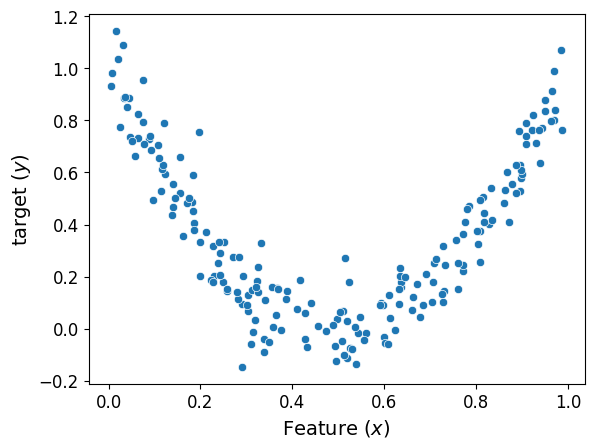

In [16]:
sns.scatterplot(x = X.flatten(), y = y.flatten())
plt.xlabel("Feature ($x$)")
plt.ylabel("target ($y$)")

### Instanciación y entrenamiento

En un proceso real, deberíamos separar train y test, como estas son sesiones ilustrativas no lo haremos.

In [17]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42) # De nuevo sólo un hiperparámetro, para controlar la profundidad o número de niveles del árbol
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [18]:
y_pred = tree_reg.predict(X)

print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

MAE: 0.11551247800933064
RMSE: 0.14103255657883856


Probemos ahora con un árbol de algo más de profundidad

In [19]:
tree_reg_bis = DecisionTreeRegressor(max_depth=3, random_state=42) # De nuevo sólo un hiperparámetro, para controlar la profundidad o número de niveles del árbol
tree_reg_bis.fit(X, y)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [20]:
y_pred = tree_reg_bis.predict(X)

print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

MAE: 0.08517327912899003
RMSE: 0.10516692756390263


Hemos mejorado pero tendríamos que haber porbado una validación cruzada para estar más seguros

In [21]:
from sklearn.model_selection import cross_val_score

level_2 = np.sqrt(-cross_val_score(tree_reg, X, y, cv = 5, scoring= "neg_mean_squared_error"))
level_3 = np.sqrt(-cross_val_score(tree_reg_bis, X, y, cv = 5, scoring = "neg_mean_squared_error"))

print("Arbol 2 niveles:", level_2.mean())
print("Arbol 3 niveles:", level_3.mean())

Arbol 2 niveles: 0.1703701065551966
Arbol 3 niveles: 0.1255889505623447


Por ahora podríamos "fiarnos" (pero sería mejor tener Test, ¿verdad?)

### Visualización del árbol


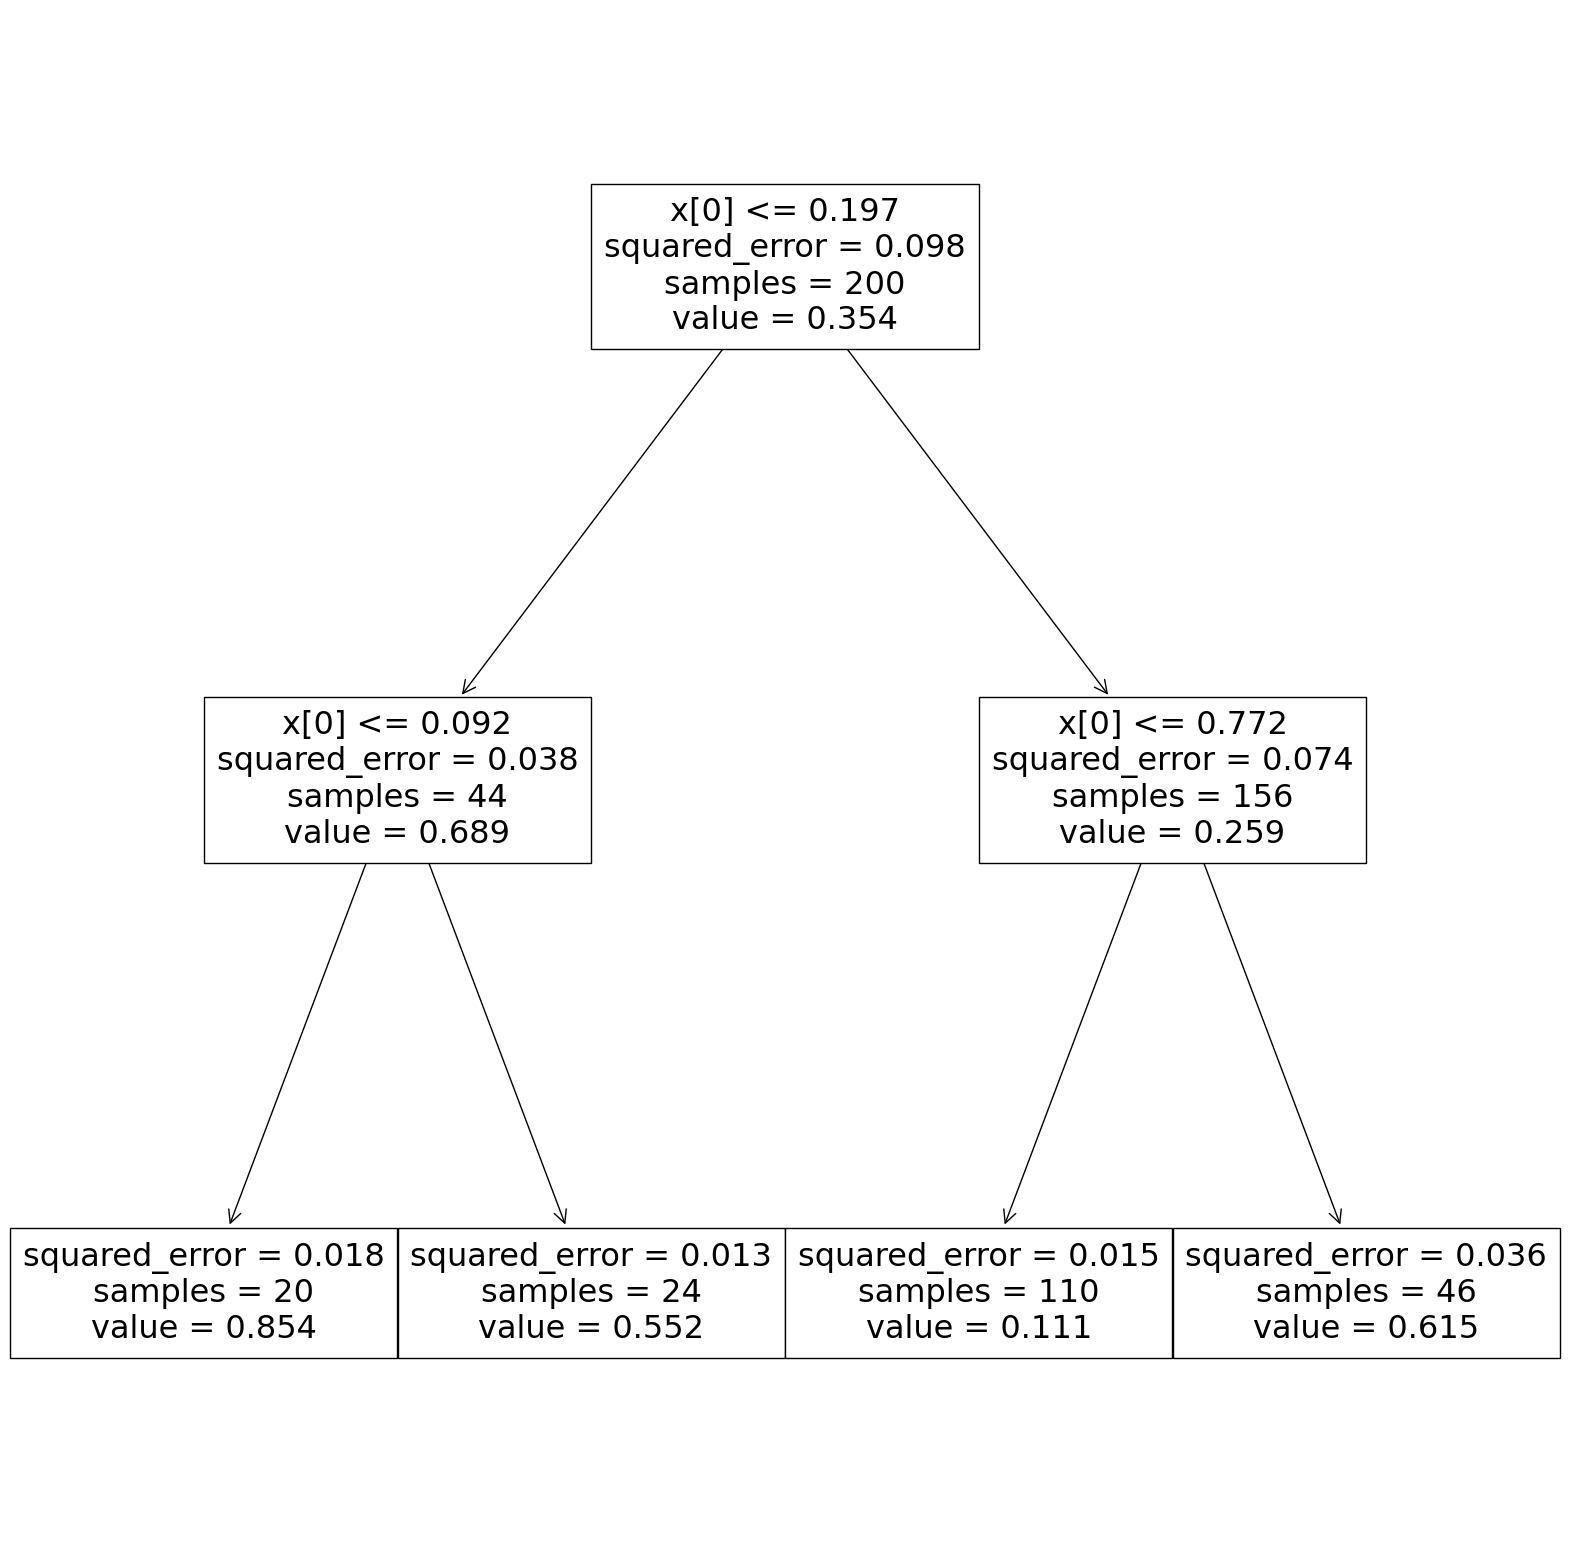

In [22]:
plt.figure(figsize=(20,20))
plot_tree(tree_reg);

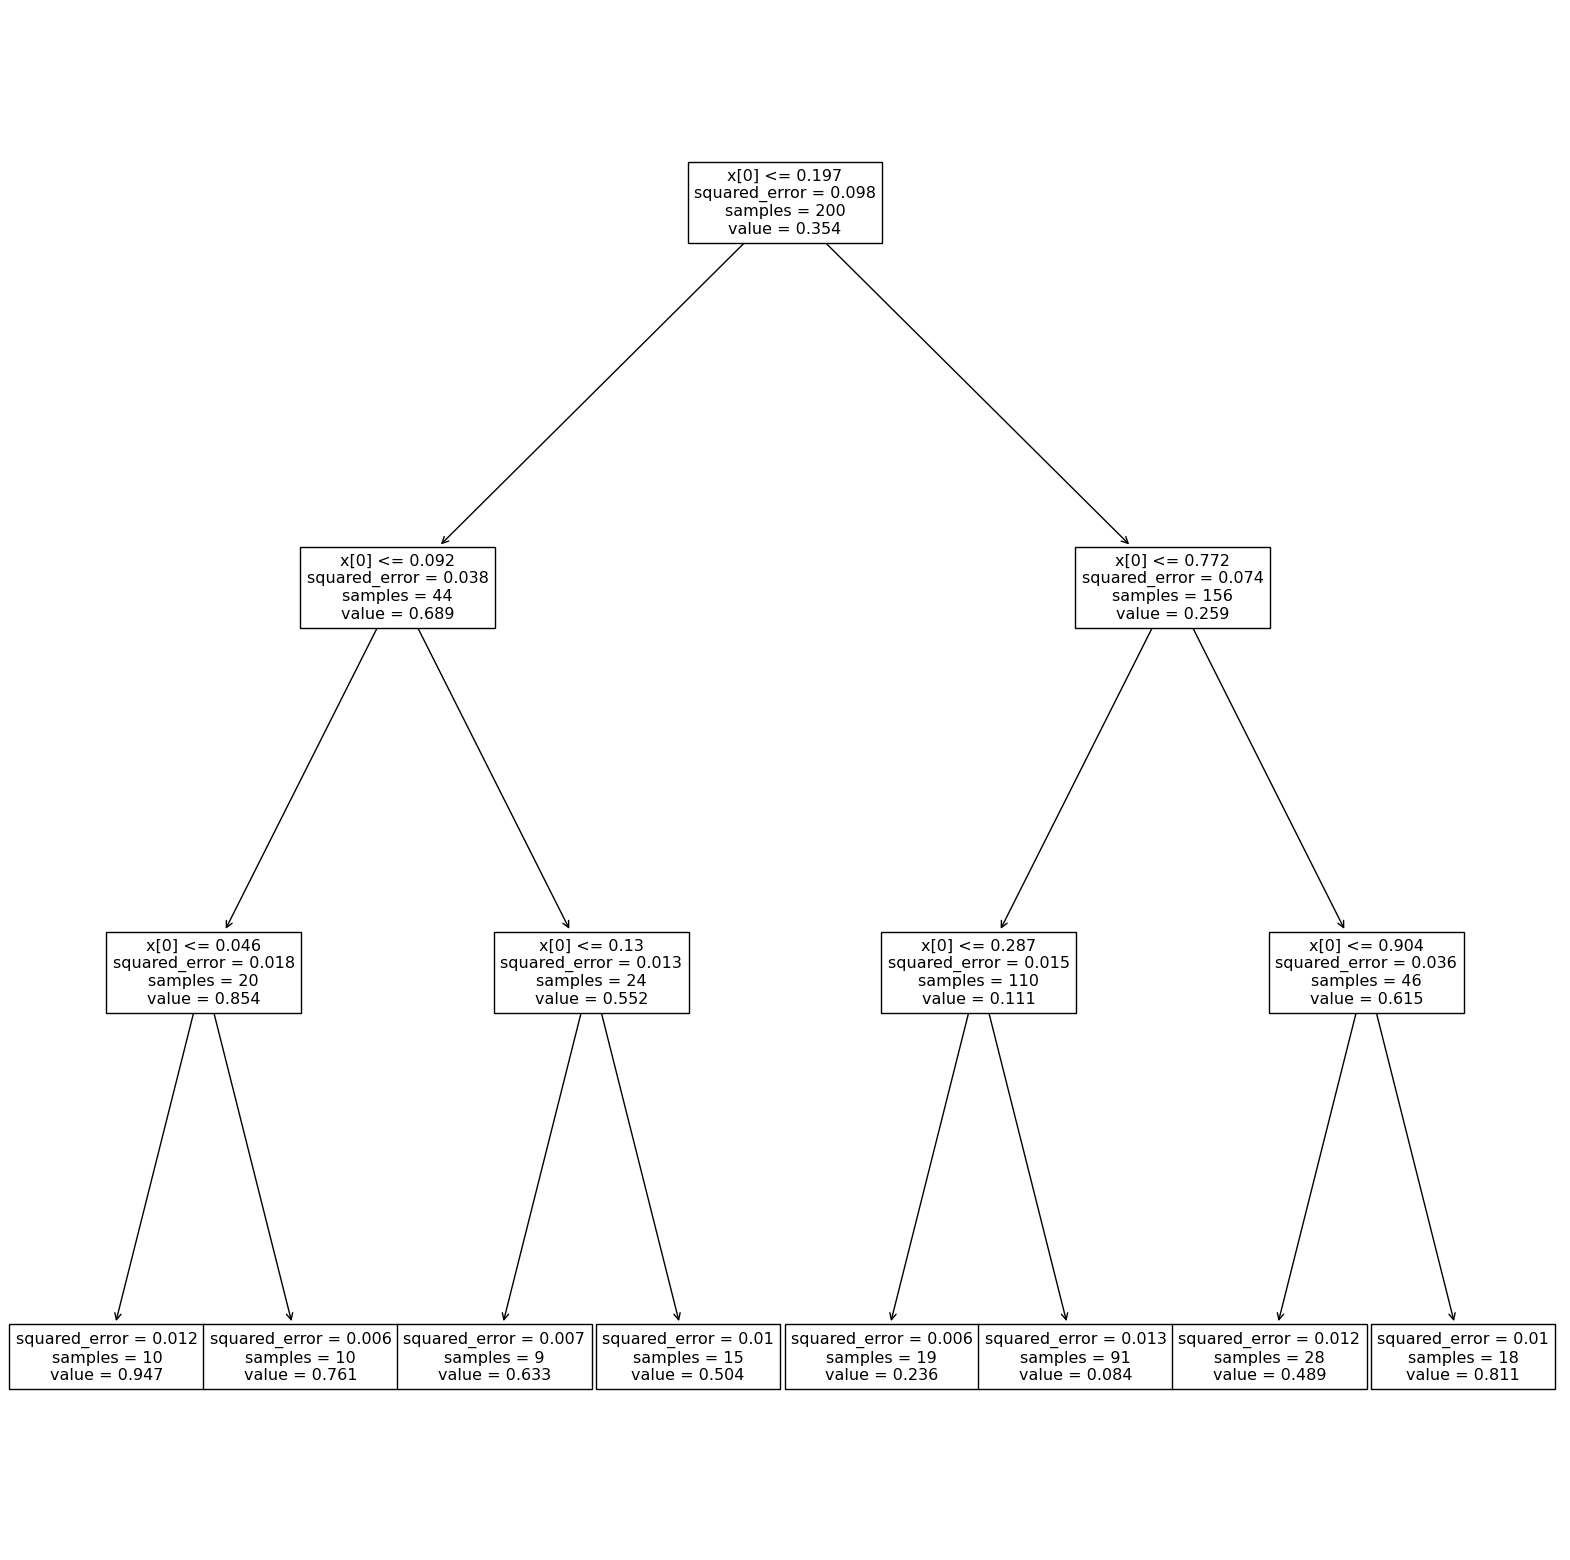

In [23]:

plt.figure(figsize=(20,20))
plot_tree(tree_reg_bis);

### Visualización del funcionamiento

Ahora vamos a definir una función que nos va a ayudar a ver gráficamente como se construyen esos umbrales que vimos en las sesiones teóricas que aplica el árbol de decisión cuando se enfrenta a problemas de regresión

In [24]:
def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

Le paseremos el modelo y los datos y nos pintará todo lo necesario, veámoslo en acción

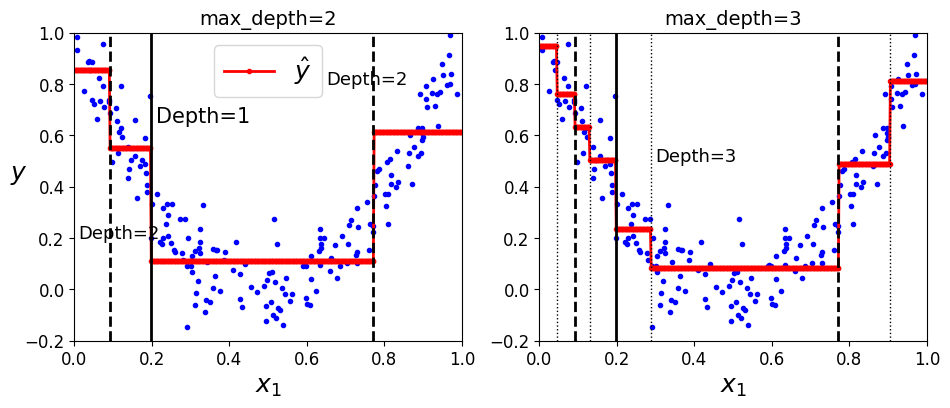

In [25]:
plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_regression_predictions(tree_reg, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=1", fontsize=15)
plt.text(0.01, 0.2, "Depth=2", fontsize=13)
plt.text(0.65, 0.8, "Depth=2", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)
plot_regression_predictions(tree_reg_bis, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=3", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

### Overfitting

Para termrminar, veamos la capacidad de hacer overfitting de los árboles, incluso los de regresión (recuerda el ejemplo del proceso de ML con el que comenzamos el módulo). Vamos a entrenar un modelo sin restricciones en el nivel de profundidad y otro sin restricciones en el nivel de profundidad pero sí en el mínimo número de elementos que tiene que tener una hoja.

In [26]:
tree_reg_limitless = DecisionTreeRegressor(random_state=42) # Sin restricciones en el número de niveles del árbol
tree_reg_min_leaf = DecisionTreeRegressor(random_state=42, min_samples_leaf=10) # Restringidos los niveles a que no haya hojas con menos de 10 elementos
tree_reg_limitless.fit(X, y)
tree_reg_min_leaf.fit(X, y)

DecisionTreeRegressor(min_samples_leaf=10, random_state=42)

Veamos que tal se comportan sus métricas en train y luego en cross-validation:

**Sin límites, train error**

In [27]:
y_pred = tree_reg_limitless.predict(X)

print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

MAE: 0.0
RMSE: 0.0


Hmmm, sospechoso, doesn't it?

**Con minimo número de muestras por hoja, train error**

In [28]:
y_pred = tree_reg_min_leaf.predict(X)

print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

MAE: 0.06938429475117905
RMSE: 0.08772030436846634


Sensiblemente mejor que los entrenados al principio, pero.... Veamos con CV

**Score en validación cruzada**

In [29]:
level_2 = np.sqrt(-cross_val_score(tree_reg_limitless, X, y, cv = 5, scoring= "neg_mean_squared_error"))
level_3 = np.sqrt(-cross_val_score(tree_reg_min_leaf, X, y, cv = 5, scoring = "neg_mean_squared_error"))

print("Arbol a lo suyo:", level_2.mean())
print("Arbol con limite en las hojas:", level_3.mean())

Arbol a lo suyo: 0.1299083225118831
Arbol con limite en las hojas: 0.11286638978822128


Han empeorado, incluso el sin límites por debajo del que tiene las hojas restringidas a un mínimo y por debajo del arbol de tres niveles. Veamos como han escogido sus valores gráficamente:

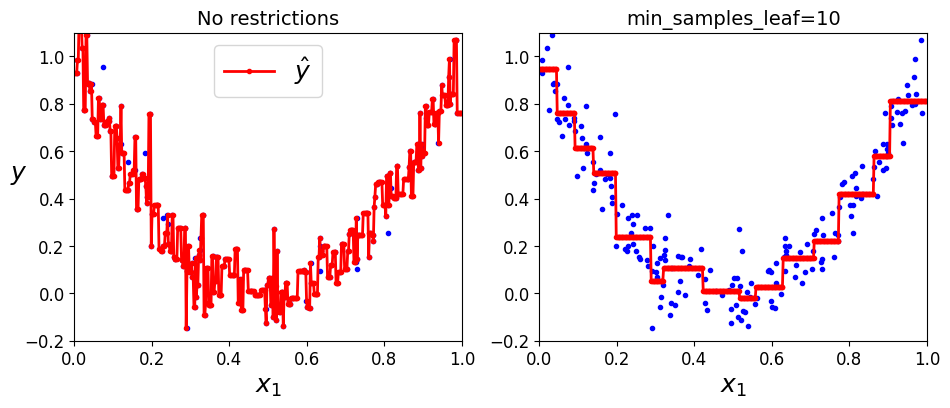

In [30]:
x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg_limitless.predict(x1)
y_pred2 = tree_reg_min_leaf.predict(x1)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.subplot(122)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg_min_leaf.min_samples_leaf), fontsize=14);

El overfitting es clarísimo en la figura de la izquierda, mientras que en la derecha podemos ver un cierto sobreajuste pero una mejor selección de umbrales. La cuestión importante que se nos plantea con modelos como los árboles, que pueden ser muy interesantes, es ¿cuál es la combinación de hiperparámetros adecuada para obtener ese punto deseado de compromiso entre error de train y error de test, entre bias y variance?

## AJUSTE DE HIPERPARAMETROS DE FORMA PRACTICA

En Machine Learning, la mayoría de los modelos tienen hiperparámetros que deben ajustarse para conseguir mejores predicciones. 

Por ejemplo, en el modelo de **Elastic Net**, teníamos la siguiente función de error:


donde hay dos parámetros $\lambda_1$ y $\lambda_2$ que debemos optimizar para que el modelo ofrezca los mejores resultados posibles.


¿Por qué se llaman hiperparámetros y no parámetros? La diferencia es que los hiperparámetros hay que fijarlos antes de entrenar, mientras que los parámetros son aquellos que se ajustan en el entrenamiento. En el caso de Elastic Net, los hiperparámetros serían $\lambda_1$ y $\lambda_2$ mientras que los parámetros serían $w_0$, $w_1$, $w_2$... 


Los dos métodos más utilizados para optimizar hiperparámetros son **Random Search** y **Grid Search**. Ambas técnicas se aplican con el método de **Cross Validation**. 



![Captura de pantalla 2024-01-28 104726.png](<attachment:Captura de pantalla 2024-01-28 104726.png>)
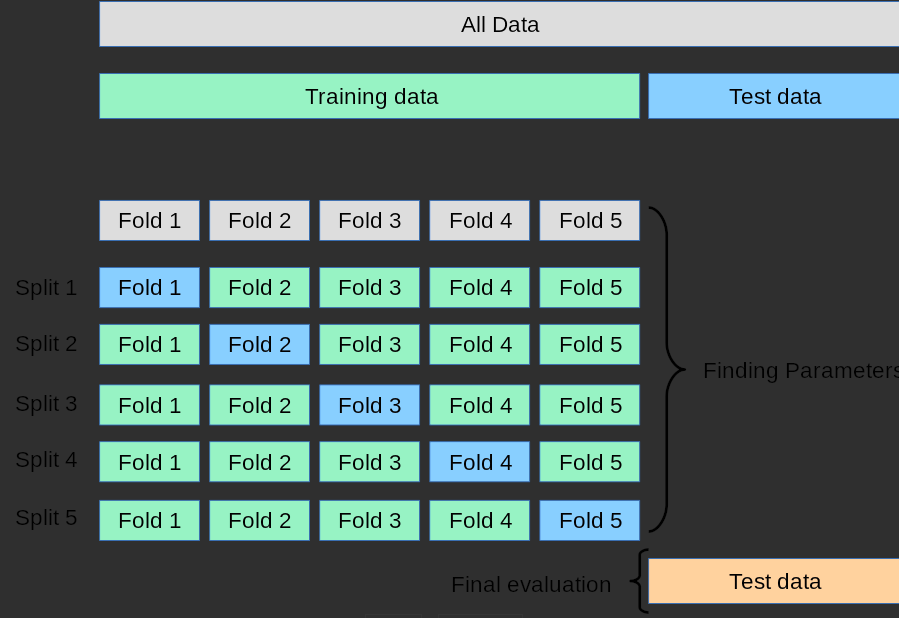

## Random Search
Como su propio nombre indica, utiliza combinaciones aleatorias de los hiperparámetros. Esto implica que no se van a probar todos los posibles valores, sino algunos muestreados de forma aleatoria. En primer lugar, se divide el dominio de hiperparámetros en un grid. Después, se seleccionan combinaciones aleatorias hasta llegar a un número máximo de iteraciones, quedándose con la mejor combinación de todas las evaluadas. 

Esta opción es recomendable cuando tenemos muchos hiperparámetros con muchos posibles valores 
![image.png](attachment:image.png)

In [31]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import ElasticNet


In [32]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=42)

In [33]:
param_grid = {
    'alpha': [1e-10, 1e-4, 1e-2, 1, 5, 10, 20, 40],
    'l1_ratio': np.arange(0,1,0.01)
}

elastic = ElasticNet()

random_search = RandomizedSearchCV(elastic, # El modelo que quiero entrenar
                                   param_grid, # El grid de parámetros
                                   random_state=1, # Semilla
                                   n_iter=100, # Nº de iteraciones del random search
                                   cv=5, # Folds del cross validation
                                   scoring="neg_root_mean_squared_error", # Métrica que quiero optimizar
                                   n_jobs = -1 # Paralelizar
                                  )

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=ElasticNet(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [1e-10, 0.0001, 0.01, 1, 5, 10,
                                                  20, 40],
                                        'l1_ratio': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])},
                   random_state=1, scoring='neg_root_mean_squared_error')

In [34]:
# Mejores parámetros del modelo
random_search.best_params_

{'l1_ratio': 0.01, 'alpha': 0.0001}

In [35]:
# Mejor score (R2)
random_search.best_score_**2

3119.8132776573457

In [ ]:
# random_search.best_estimator_ contiene el mejor modelo

In [36]:
random_search.best_estimator_.coef_

array([  41.95188923, -227.26043042,  536.22030113,  333.70496   ,
       -208.95856276,  -32.17178006, -156.20483528,  169.91693151,
        448.88133911,   64.35253694])

In [37]:
random_search.best_estimator_.score(X_test, y_test)

0.45811580159405374

In [38]:
# Es equivalente a hacer esto:
from sklearn.metrics import mean_squared_error

model = ElasticNet(alpha=0.0001, l1_ratio=0.01)
model.fit(X_train, y_train)
print(model.score(X_train,y_train))
print("RMSE_train", mean_squared_error(y_train, model.predict(X_train), squared = False))
print(model.score(X_test, y_test))
print("RMSE_test", mean_squared_error(y_test, model.predict(X_test), squared = False))




0.5240027096996049
RMSE_train 53.780563300949
0.45811580159405374
RMSE_test 53.581570649599115


In [39]:
# Compruebo que los coeficientes coinciden con el best_estimator_
model.coef_

array([  41.95188923, -227.26043042,  536.22030113,  333.70496   ,
       -208.95856276,  -32.17178006, -156.20483528,  169.91693151,
        448.88133911,   64.35253694])

¿Funciona mejor que una regresión lineal sin regularización?

In [40]:
from sklearn.linear_model import LinearRegression
diabetes_model = LinearRegression()
diabetes_model.fit(X_train, y_train)
print(diabetes_model.score(X_train,y_train))
print("RMSE", mean_squared_error(y_train, diabetes_model.predict(X_train), squared = False))
print(diabetes_model.score(X_test, y_test))
print("RMSE", mean_squared_error(y_test, diabetes_model.predict(X_test), squared = False))


0.5279193863361498
RMSE 53.55884336723094
0.4526027629719197
RMSE 53.853445836765914


## Grid Search
Este método prueba todas las combinaciones del grid y evalúa el modelo para cada combinación, también usando cross-validation para cada una. 
Es más lento que Random Search, ya que prueba todas las posibles combinaciones. La ventaja es que te aseguras haber encontrado la mejor de todas al finalizar el proceso, lo que no te garantizaba Random Search. 


In [42]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [1e-10, 1e-4, 1e-2, 1, 5, 10, 20, 40],
    'l1_ratio': np.arange(0, 1, 0.01)
}

elastic = ElasticNet()

grid_search = GridSearchCV(elastic,
                           param_grid,
                           cv=5,
                           scoring='r2',
                           n_jobs=-1
                          )

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [1e-10, 0.0001, 0.01, 1, 5, 10, 20, 40],
                         'l1_ratio': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])},
             scoring='r2')

In [43]:
grid_search.best_params_

{'alpha': 0.01, 'l1_ratio': 0.97}

In [44]:
grid_search.best_score_

0.4563664652073977

In [45]:
# R2 en test
grid_search.best_estimator_.score(X_test, y_test)

0.46261528610078473

In [46]:
# Es equivalente a hacer esto:
from sklearn.metrics import mean_squared_error

model = ElasticNet(alpha=0.01, l1_ratio=0.97)
model.fit(X_train, y_train)
print(model.score(X_train,y_train))
print("RMSE_train", mean_squared_error(y_train, model.predict(X_train), squared = False))
print(model.score(X_test, y_test))
print("RMSE_test", mean_squared_error(y_test, model.predict(X_test), squared = False))


0.519618926774386
RMSE_train 54.02764661563131
0.46261528610078473
RMSE_test 53.35865217161338


Hemos obtenido el mejor resultado con Grid Search, ya que ha evaluado todas las posibles combinaciones, quedándose con la mejor.

## Bayesian Search
Existe un tercer método para ajustar los hiperparámetros del modelo: la optimización bayesiana, que utiliza métodos probabilísticos para elegir y probar la siguiente combinación de hiperparámetros. Con esta estrategia, se consigue que la búsqueda se vaya redirigiendo en cada iteración hacia las regiones de mayor interés. 

El objetivo final es reducir el número de combinaciones de hiperparámetros con las que se evalúa el modelo, eligiendo únicamente los mejores candidatos. La ventaja frente a las otras estrategias mencionadas es el ahorro de tiempo cuando el espacio de búsqueda es muy amplio o la evaluación del modelo es muy lenta.



La librería Hyperopt nos permite aplicar la optimización bayesiana

In [47]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

In [48]:
def hyperopt_train_test(params, scoring = "r2"):
    model = ElasticNet(**params)
    return cross_val_score(model, X_train, y_train, 
                           cv=5, scoring= scoring).mean() # Aquí la métrica es r2 pero podemos poner la que queramos de las admitidas por la validación cruzada de sklearn


# Defininmos el "grid" (hiperparámetros y rango de valores)
space = {
    'alpha': hp.uniform('alpha', 0.0001, 1.0),
    'l1_ratio': hp.uniform('l1_ratio', 0.0001, 1.0)
}

def f(params):
    r2 = hyperopt_train_test(params)
    return {'loss':-r2, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=100, trials=trials)

100%|██████████| 100/100 [00:00<00:00, 157.54trial/s, best loss: -0.45636525940077]


In [49]:
best # Esto nos devuelve la combinación optima encontrada 

{'alpha': 0.010040917713042014, 'l1_ratio': 0.97075312639559}

In [50]:
model_bayes = ElasticNet(alpha=best['alpha'], l1_ratio=best['l1_ratio'])
model_bayes.fit(X_train, y_train)
model_bayes.score(X_test, y_test)

0.46259478237822615

Más información sobre los espacios de búsqueda de hyperopt: http://hyperopt.github.io/hyperopt/getting-started/search_spaces/